In [1]:
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import urbanpy as up
import contextily as cx
from pathlib import Path
from pandarallel import pandarallel
from shapely.geometry import Polygon

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pandarallel.initialize(progress_bar=True, nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Geocoding con un Nomatin Server

## Leemos los datos a usar

In [3]:
df = pd.read_stata('inputs/rucs_firmas_20142020.dta')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240151 entries, 0 to 240150
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ruc                   240151 non-null  float64
 1   CODIGO_TIPO_VIA       240151 non-null  object 
 2   DESCRIPCION_TIPO_VIA  240151 non-null  object 
 3   NOMBRE_VIA            240151 non-null  object 
 4   PUERTA                240151 non-null  object 
 5   MANZANA               240151 non-null  object 
 6   LOTE                  240151 non-null  object 
 7   PISO                  240151 non-null  object 
 8   INTERIOR              240151 non-null  object 
 9   DIR_DPTO              240151 non-null  object 
 10  KILOMETRO             240151 non-null  object 
 11  REFERENCIA            240151 non-null  object 
 12  DIR_TIPOZONA          240151 non-null  object 
 13  tipo_zona             240151 non-null  object 
 14  DIR_NOMZONA           240151 non-null  object 
 15  

In [5]:
departamentos = gpd.read_file('inputs/departamentos/')

In [6]:
res = 4
peru_hexs = up.geom.gen_hexagons(res, departamentos)
print(f'Hex count @ res {res}:', peru_hexs.shape[0])

/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/urbanpy/geom/geom.py:168: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  city_poly = city.explode().reset_index(drop=True)


Hex count @ res 4: 634


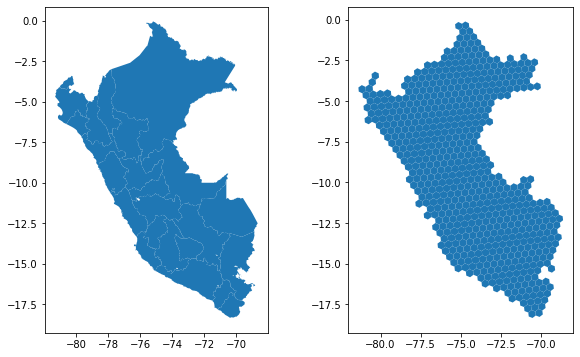

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
departamentos.plot(ax=axes[0])
peru_hexs.plot(ax=axes[1])
plt.show()

## Preparamos las funciones para geocodificar

In [10]:
def geocode(row, server='https://nominatim.openstreetmap.org/'):
    params = {'q': row['q'], 'limit': 1, 'format': 'json'}
    response = requests.get(server+'/search', params=params)
    data = response.json()
    if server == 'https://nominatim.openstreetmap.org/':
        time.sleep(1) # Usage limits
    return data

In [11]:
def geocoding_process(fn, df, geocode_fn):
    if Path(fn+'.csv').exists():
        geocoded_df = pd.read_csv(fn+'.csv', index_col=0)
    else:
        geocoded = df.parallel_apply(geocode_fn, axis=1, server=NOMINATIM_SERVER)
        geocoded_exploded = geocoded.explode() # unpack lists
        # NaNs
        print('Geocoded values (%):')
        print(geocoded_exploded.isna().value_counts())
        print(geocoded_exploded.isna().value_counts() / geocoded.shape[0])

        geocoded_df = pd.json_normalize(geocoded_exploded) # Series of dicts -> DataFrame
        geocoded_df.to_csv(fn+'.csv')

    print('OSM Data types')
    print(geocoded_df['osm_type'].value_counts())
    print('OSM Class')
    print(geocoded_df['class'].value_counts())
    print('OSM Class type')
    print(geocoded_df['type'].value_counts())

    if Path(fn+'.geojson').exists():
        geocoded_gdf = gpd.read_file(fn+'.geojson')
    else:
        geocoded_gdf = gpd.GeoDataFrame(
            data=geocoded_df,
            geometry=gpd.points_from_xy(geocoded_df['lon'], geocoded_df['lat']),
            crs='EPSG:4326'
        )
        geocoded_gdf = geocoded_gdf.drop('boundingbox', axis=1) # Can't save list type in geojson format
        geocoded_gdf.to_file(fn+'.geojson', driver='GeoJSON')

    print('GeoDataFrame (first 5 observations)')
    print(geocoded_gdf.head())
    
    # Point map
    ax = geocoded_gdf.plot(figsize=(10, 10))
    cx.add_basemap(ax, crs=geocoded_gdf.crs, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    plt.show()

    # Count points per hexagon
    geocoded_gdf['count'] = 1
    peru_hexs_counts = up.geom.merge_shape_hex(peru_hexs, geocoded_gdf.dropna(), agg={'count':'sum'})
    print(peru_hexs_counts.describe())
    ax = peru_hexs_counts.plot('count', vmin=0, vmax=200, figsize=(30,10), legend=True, alpha=0.5)
    cx.add_basemap(ax, crs=geocoded_gdf.crs, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    plt.show()
    
    return geocoded_df, geocoded_gdf

## Primero filtraremos los que sí tienen "NOMBRE_VIA" y "PUERTA" e intentaremos geocodificarlas

In [12]:
NOMINATIM_SERVER = 'http://192.168.18.18:8080'

In [13]:
filter_ = (df['NOMBRE_VIA'] != '-') & (~df['PUERTA'].isin(['-','S/N','SN','']))

In [14]:
columns = ['PUERTA', 'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'DISTRITO', 'PROVINCIA', 'DEPARTAMENTO', 'UBIGEO']
indexs = df[filter_].index

In [15]:
df.shape, indexs.shape, indexs.shape[0]/df.shape[0]

((240151, 29), (161327,), 0.671773176043406)

In [16]:
df_sample = df.loc[indexs, columns]

In [17]:
df_sample['street_name'] = df_sample[['DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA', 'PUERTA']].apply(lambda x: ' '.join(x).lower(), axis=1)
df_sample['location'] = df_sample[['DISTRITO', 'PROVINCIA', 'DEPARTAMENTO']].apply(lambda x: ', '.join(x).lower(), axis=1)
df_sample['q'] = df_sample[['street_name', 'location']].apply(lambda x: ', '.join(x).lower(), axis=1)

In [18]:
df_sample['q']

0                jiron apurimac 521, callao, callao, callao
1            avenida argentina 1646, callao, callao, callao
2         avenida augusto perez aranibar 1872, san isidr...
3            avenida argentina 3719, callao, callao, callao
5            avenida argentina 6360, callao, callao, callao
                                ...                        
240144       avenida costanera 2576, san miguel, lima, lima
240145    avenida sergio bernales 347, surquillo, lima, ...
240146    calle micaela bastidas 202, villa maria del tr...
240147    calle prohogar 918, miraflores, arequipa, areq...
240148    calle baca mattos 1194, lambayeque, lambayeque...
Name: q, Length: 161327, dtype: object

OSM Data types
way         97012
node         4890
relation      212
Name: osm_type, dtype: int64
OSM Class
highway     88654
place        6261
building     2132
shop         1785
amenity      1640
office       1217
tourism       291
leisure        57
craft          30
landuse        22
boundary        7
man_made        5
club            5
natural         4
aeroway         2
historic        1
waterway        1
Name: class, dtype: int64
OSM Class type
residential         47229
secondary           15351
tertiary            11539
primary              9441
house                6139
                    ...  
parking_entrance        1
locksmith               1
mobile_phone            1
taxi                    1
cemetery                1
Name: type, Length: 217, dtype: int64
GeoDataFrame (first 5 observations)
   place_id                                            licence osm_type  \
0  480319.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
1  336252.0  Data © OpenStreetMap c

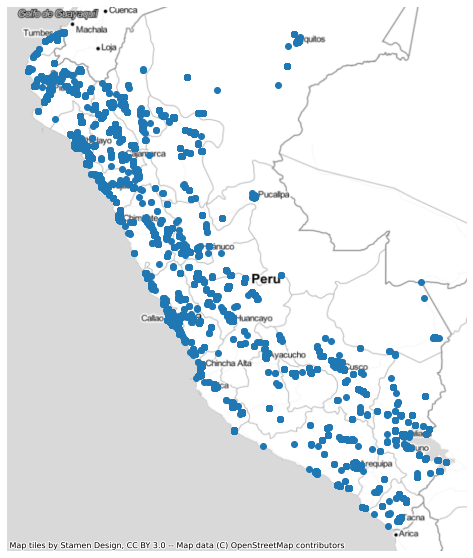

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_48991/1200115963.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_df, geocoded_gdf = geocoding_process(


              count
count    222.000000
mean     450.184685
std     4181.623995
min        1.000000
25%        4.000000
50%       19.000000
75%      114.000000
max    62029.000000


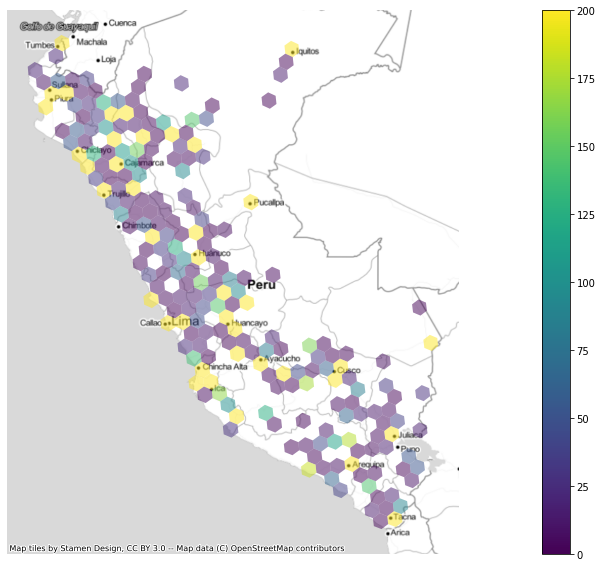

In [20]:
geocoded_df, geocoded_gdf = geocoding_process(
    fn='outputs/geocoded_df', df=df_sample, geocode_fn=geocode)

In [49]:
geocoded_df

,place_id,licence,osm_type,osm_id,boundingbox,lat,lon,display_name,class,type,importance
0,480319.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,326819625.0,"['-12.0643987', '-12.0640482', '-77.1438679', ...",-12.064195,-77.142408,"Jirón Apurímac, Callao, Lima Metropolitana, Ca...",highway,residential,0.4
1,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,"['-12.0517223', '-12.0514915', '-77.1390019', ...",-12.051599,-77.136316,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,"['-12.0517223', '-12.0514915', '-77.1390019', ...",-12.051599,-77.136316,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6
...,...,...,...,...,...,...,...,...,...,...,...
161322,784025.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,834794998.0,"['-12.0857688', '-12.0849072', '-77.098001', '...",-12.085307,-77.097026,"Avenida Costanera, San Miguel, Lima, Lima Metr...",highway,primary,0.7
161323,345848.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,24332076.0,"['-12.1185992', '-12.1160772', '-77.0183159', ...",-12.118151,-77.015250,"Avenida Sergio Bernales, Surquillo, Lima, Lima...",highway,tertiary,0.7
161324,508780.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,408678500.0,"['-12.1369273', '-12.1363412', '-76.9492306', ...",-12.136927,-76.949231,"Calle Micaela Bastidas, Villa María del Triunf...",highway,residential,0.9
161325,593409.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,538094089.0,"['-16.394911', '-16.3942407', '-71.5220514', '...",-16.394390,-71.521592,"Prohogar, Las Palmeras, Miraflores, Arequipa, ...",highway,tertiary,0.5


In [50]:
geocoded_gdf

,place_id,licence,osm_type,osm_id,lat,lon,display_name,class,type,importance,geometry,count
0,480319.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,326819625.0,-12.0641953,-77.1424078,"Jirón Apurímac, Callao, Lima Metropolitana, Ca...",highway,residential,0.4,POINT (-77.14241 -12.06420),1
1,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,-12.0515994,-77.1363159,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6,POINT (-77.13632 -12.05160),1
2,NaN,None,None,NaN,None,None,None,None,None,NaN,None,1
3,NaN,None,None,NaN,None,None,None,None,None,NaN,None,1
4,336252.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,43476929.0,-12.0515994,-77.1363159,"Avenida Argentina, Nuevo Puerto, Callao, Lima ...",highway,primary,0.6,POINT (-77.13632 -12.05160),1
...,...,...,...,...,...,...,...,...,...,...,...,...
161322,784025.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,834794998.0,-12.0853067,-77.0970258,"Avenida Costanera, San Miguel, Lima, Lima Metr...",highway,primary,0.7,POINT (-77.09703 -12.08531),1
161323,345848.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,24332076.0,-12.1181506,-77.0152499,"Avenida Sergio Bernales, Surquillo, Lima, Lima...",highway,tertiary,0.7,POINT (-77.01525 -12.11815),1
161324,508780.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,408678500.0,-12.1369273,-76.9492306,"Calle Micaela Bastidas, Villa María del Triunf...",highway,residential,0.9,POINT (-76.94923 -12.13693),1
161325,593409.0,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,538094089.0,-16.3943896,-71.5215922,"Prohogar, Las Palmeras, Miraflores, Arequipa, ...",highway,tertiary,0.5,POINT (-71.52159 -16.39439),1


### Ahora limpiaremos las direcciones de las observaciones que no pudieron ser geocodificadas en el caso anterior

In [21]:
df_retry_ix = df_sample[geocoded_df['lat'].isna().values].index

In [22]:
df_retry = df.loc[df_retry_ix, :]

In [23]:
df_sample.shape, df_retry.shape

((161327, 10), (59213, 29))

### Podemos utilizar los datos del censo a nivel de manzana para georrefenciar aproximadamente algunas firmas

In [24]:
censo_mz = gpd.read_file('inputs/Manzanas/')

In [25]:
censo_mz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 106889 entries, 0 to 106888
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDMANZANA   106889 non-null  object  
 1   CODZONA     81320 non-null   object  
 2   CODMZNA     81346 non-null   object  
 3   CLASIFICAC  106889 non-null  int64   
 4   UBIGEO      106889 non-null  object  
 5   NOMBREMZNA  57384 non-null   object  
 6   URBANIZACI  83527 non-null   object  
 7   NSE07       59635 non-null   object  
 8   POB07       106889 non-null  int64   
 9   VIV07       106889 non-null  int64   
 10  NSE16       78221 non-null   object  
 11  POB16       106889 non-null  int64   
 12  VIV         106889 non-null  int64   
 13  LONGITUDE   106889 non-null  float64 
 14  LATITUDE    106889 non-null  float64 
 15  geometry    106889 non-null  geometry
dtypes: float64(2), geometry(1), int64(5), object(8)
memory usage: 13.0+ MB


In [26]:
geo_cols = ['IDMANZANA', 'LATITUDE', 'LONGITUDE']
censo_mz_cods = censo_mz[censo_mz['CODMZNA'].notna()][geo_cols]

In [27]:
censo_cols = ['CNS_UBIGEO', 'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL']
df_retry_censo = df_retry[~df_retry['CNS_MZ_CENSAL'].isin(['', 'NUL'])][censo_cols]
df_retry_censo['IDMANZANA'] = df_retry_censo.sum(axis=1)

In [29]:
df_retry_censo_geocoded = df_retry_censo.reset_index().merge(
    censo_mz_cods, on='IDMANZANA', how='inner').set_index('index')

In [30]:
df_retry_censo_geocoded.shape

(920, 7)

### Ahora intentemos utilizar el servidor de Nominatim de nuevo pero facilitemos la busqueda indicandole el area geografica del distrito donde debe buscar la direccion

In [31]:
distritos = gpd.read_file('inputs/distritos/')

In [32]:
distritos.shape, distritos['IDDIST'].unique().shape

((1873, 11), (1873,))

In [33]:
distritos[['minx', 'miny', 'maxx', 'maxy']] = distritos.geometry.bounds

In [34]:
df_retry.shape

(59213, 29)

In [35]:
df_retry_nominatim = df_retry.drop(df_retry_censo_geocoded.index)

In [36]:
def geocode_w_poly(row, server='https://nominatim.openstreetmap.org/'):
    params = {'q': row['q'], 'limit': 1, 'format': 'json', 'bounded': 1,
              'viewbox':','.join([str(val) for val in row[['minx', 'miny', 'maxx', 'maxy']]])}
    response = requests.get(server+'/search', params=params)
    data = response.json()
    if server == 'https://nominatim.openstreetmap.org/':
        time.sleep(1) # Usage limits
    return data

In [37]:
df_retry_nominatim_vb = df_retry_nominatim.reset_index().merge(
    distritos[['IDDIST', 'minx', 'miny', 'maxx', 'maxy']], 
    how='inner',
    left_on='UBIGEO', 
    right_on='IDDIST'
).set_index('index')

In [38]:
df_retry_nominatim_vb.shape

(58284, 34)

In [39]:
df_retry_nominatim_vb['q'] = df_retry_nominatim_vb['NOMBRE_VIA'] + ' ' + df_retry_nominatim_vb['PUERTA']
df_retry_nominatim_vb['q'] = df_retry_nominatim_vb['q'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True).str.lower()
df_retry_nominatim_vb['q']

index
2           augusto perez aranibar 1872
86                         calle 31 125
123       francisco canaval y morey 522
238                    las begonias 415
256                        calle 25 195
                      ...              
232196                   cocochillo 325
233814       bernardo guebles meier 356
234300                predio panteon i 
235192                       arequipa 0
238696           jorge chavez darwin 15
Name: q, Length: 58284, dtype: object

Geocoded values (%):
True     37677
False    20607
dtype: int64
True     0.646438
False    0.353562
dtype: float64
OSM Data types
way         19629
node          843
relation      134
Name: osm_type, dtype: int64
OSM Class
highway     18937
place         897
amenity       179
building      167
shop          105
landuse        98
office         94
tourism        55
boundary       55
leisure         5
aeroway         4
craft           3
waterway        3
man_made        2
natural         2
historic        1
Name: class, dtype: int64
OSM Class type
residential         14717
tertiary             1721
secondary            1337
house                 571
primary               300
                    ...  
stationery              1
motorcycle              1
amusement_arcade        1
association             1
peak                    1
Name: type, Length: 123, dtype: int64


/Users/claudio/.pyenv/versions/peru-connect-env/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


GeoDataFrame (first 5 observations)
   place_id                                            licence osm_type  \
0       NaN                                                NaN      NaN   
1  330523.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   
2       NaN                                                NaN      NaN   
3       NaN                                                NaN      NaN   
4  325709.0  Data © OpenStreetMap contributors, ODbL 1.0. h...      way   

       osm_id          lat          lon  \
0         NaN          NaN          NaN   
1  35893289.0   -12.107143   -77.013688   
2         NaN          NaN          NaN   
3         NaN          NaN          NaN   
4  35893283.0  -12.1062052  -77.0123151   

                                        display_name    class         type  \
0                                                NaN      NaN          NaN   
1  Jirón Caros Neuhaus Rizo Patrón, San Isidro, L...  highway  residential   
2                   

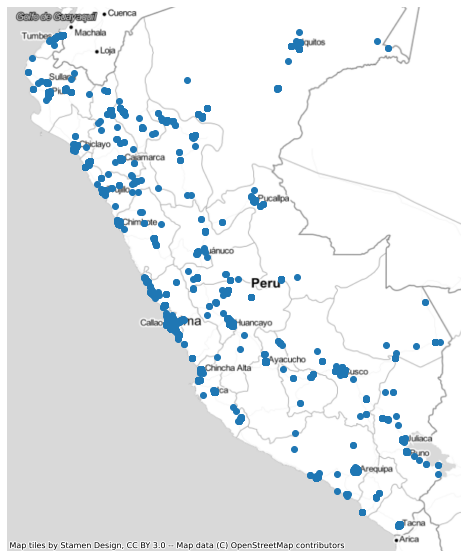

/var/folders/kb/8rst2bm96jq7g3ykfrtw15zc0000gp/T/ipykernel_48991/952200113.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  geocoded_df_retry_nominatim_vb, geocoded_gdf_retry_nominatim_vb = geocoding_process(


              count
count    149.000000
mean     136.798658
std     1164.366160
min        1.000000
25%        1.000000
50%        3.000000
75%       15.000000
max    14177.000000


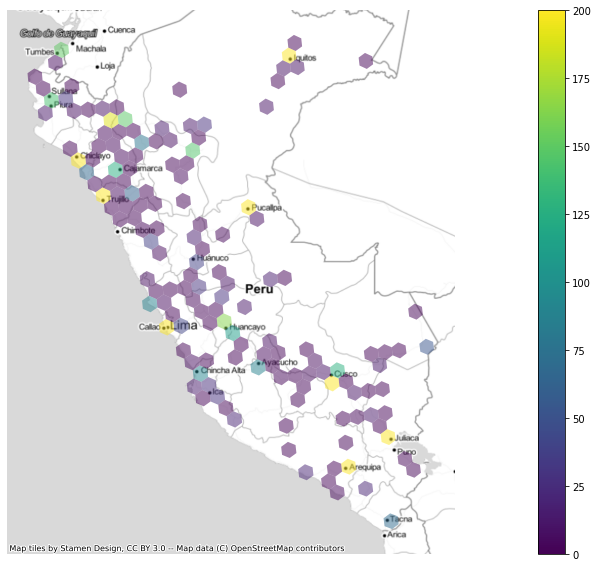

In [41]:
geocoded_df_retry_nominatim_vb, geocoded_gdf_retry_nominatim_vb = geocoding_process(
    fn='outputs/geocoded_df_retry_nominatim_vb', df=df_retry_nominatim_vb, geocode_fn=geocode_w_poly)

#### Veamos algunas direcciones geocodificadas para verificar

In [63]:
for address in geocoded_gdf_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].notna()]['display_name'].head(15).tolist():
    print(address)
    print()

Jirón Caros Neuhaus Rizo Patrón, San Isidro, Lima, Lima Metropolitana, Lima, 15000, Perú

Jirón Oscar Avilés, San Isidro, Lima, Lima Metropolitana, Lima, 15000, Perú

Calle Manuel S. Ugarte y Moscoso, Orrantia del Mar, San Isidro, Lima, Lima Metropolitana, Lima, 15076, Perú

Embajada de Alemania, 144, Avenida Dionisio Derteano, Centro financiero de San Isidro, San Isidro, Lima, Lima Metropolitana, Lima, AN ISIDRO 15036, Perú

Avenida José Galvez Barrenechea, Corpac, San Isidro, Lima, Lima Metropolitana, Lima, 15000, Perú

Miguel Dasso, San Isidro, Lima, Lima Metropolitana, Lima, 15073, Perú

Los Pelicanos, Centro financiero de San Isidro, San Isidro, Lima, Lima Metropolitana, Lima, AN ISIDRO 15036, Perú

Avenida República de Colombia, Centro financiero de San Isidro, San Isidro, Lima, Lima Metropolitana, Lima, 27, Perú

Luis Felipe Villaran, San Isidro, Lima, Lima Metropolitana, Lima, 15073, Perú

Miguel Dasso, San Isidro, Lima, Lima Metropolitana, Lima, 15073, Perú

Miguel Dasso, San 

In [68]:
df.loc[df_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].notna().values].index, :][['NOMBRE_VIA', 'DISTRITO', 'PROVINCIA']].head(15)

,NOMBRE_VIA,DISTRITO,PROVINCIA
index,,,
86,CALLE 31,SAN ISIDRO,LIMA
256,CALLE 25,SAN ISIDRO,LIMA
351,MANUEL UGARTE Y MOSCOSO,SAN ISIDRO,LIMA
414,DIONISIO DERTEANO,SAN ISIDRO,LIMA
828,"GALVEZ BARRENECHEA, JOSE",SAN ISIDRO,LIMA
1268,MIGUEL DASSO,SAN ISIDRO,LIMA
1354,LOS PELICANOS,SAN ISIDRO,LIMA
1359,AV REPUBLICA DE COLOMBIA,SAN ISIDRO,LIMA
1399,LUIS FELIPE VILLARAN,SAN ISIDRO,LIMA


### Aun tenemos un grupo de direcciones que no pudimos goereferenciar. Una opcion podria ser utilizar el API de Nominatim en la nube (~5 horas)

In [44]:
df_second_retry_ix = df_retry_nominatim_vb[geocoded_gdf_retry_nominatim_vb['lat'].isna().values].index

In [46]:
df_second_retry = df.loc[df_second_retry_ix, :]

In [79]:
df_second_retry.head()

,ruc,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,INTERIOR,DIR_DPTO,...,CNS_FRENTE,DEPARTAMENTO,PROVINCIA,DISTRITO,CAPITAL,codigo_prov,Region,CODODEI,ODEI,UBIGEO
index,,,,,,,,,,,,,,,,,,,,,
2,2.010000e+10,01,AVENIDA,AUGUSTO PEREZ ARANIBAR,1872,-,-,,-,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
123,2.010005e+10,01,AVENIDA,FRANCISCO CANAVAL Y MOREY,522,-,-,,-,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
238,2.010009e+10,01,AVENIDA,LAS BEGONIAS,415,-,-,,1201,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
288,2.010012e+10,02,CALLE,GERMAN SCHEREIBER,276,-,-,,-,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131
305,2.010012e+10,01,AVENIDA,FELIPE PARDO Y ALIAGA,652,-,-,,1201,-,...,,LIMA,LIMA,SAN ISIDRO,SAN ISIDRO,1501,15 Provincia de Lima,15,Lima,150131


In [76]:
resp = requests.get('https://nominatim.openstreetmap.org/search',
                    params={'q': 'AVENIDA AUGUSTO PEREZ ARANIBAR 1872'.lower(), 
                            'limit': 1, 'format': 'json'})

In [77]:
resp.json()

[{'place_id': 199406294,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 435198400,
  'boundingbox': ['-12.1102297', '-12.1029232', '-77.0582336', '-77.0513587'],
  'lat': '-12.1064305',
  'lon': '-77.0550254',
  'display_name': 'Avenida Augusto Pérez Araníbar, Orrantia del Mar, San Isidro, Lima, Lima Metropolitana, Lima, 15076, Perú',
  'class': 'highway',
  'type': 'secondary',
  'importance': 0.3}]

In [82]:
censo_mz.columns

Index(['IDMANZANA', 'CODZONA', 'CODMZNA', 'CLASIFICAC', 'UBIGEO', 'NOMBREMZNA',
       'URBANIZACI', 'NSE07', 'POB07', 'VIV07', 'NSE16', 'POB16', 'VIV',
       'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

### Por ultimo buscaremos geocoficar las observaciones que no tienen direccion

#### Para comenzar veamos cuantas podemos ubicar en una manzana censal

In [ ]:
df_sin_direccion = df.drop(indexs)

In [86]:
censo_cols = ['CNS_UBIGEO', 'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL']
df_sin_direccion_censo = df_sin_direccion[~df_sin_direccion['CNS_MZ_CENSAL'].isin(['', 'NUL'])][censo_cols]
df_sin_direccion_censo['IDMANZANA'] = df_sin_direccion_censo.sum(axis=1)

In [90]:
df_sin_direccion_censo.shape

(1014, 5)

In [88]:
df_sin_direccion_censo_geocoded = df_sin_direccion_censo.reset_index().merge(
    censo_mz_cods, on='IDMANZANA', how='inner').set_index('index')

In [91]:
df_sin_direccion_censo_geocoded.shape

(445, 7)

In [89]:
df_sin_direccion_censo_geocoded

,CNS_UBIGEO,CNS_ZONA_CENSAL,CNS_MZ_CENSAL,CNS_MZSUF_CENSAL,IDMANZANA,LATITUDE,LONGITUDE
index,,,,,,,
526,070101,02800,023,,07010102800023,-12.032081,-77.096917
706,150141,00600,043,,15014100600043,-12.115487,-77.005370
1383,150113,00100,036,,15011300100036,-12.071507,-77.047043
63428,150113,00100,036,,15011300100036,-12.071507,-77.047043
1737,150117,01100,033,,15011701100033,-11.953245,-77.071592
...,...,...,...,...,...,...,...
76647,150142,04500,041,,15014204500041,-12.225491,-76.920976
76793,150117,01100,027,,15011701100027,-11.958331,-77.073607
76909,150135,03400,001,,15013503400001,-11.991927,-77.107545


In [94]:
df_sin_direccion.columns

Index(['ruc', 'CODIGO_TIPO_VIA', 'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA',
       'PUERTA', 'MANZANA', 'LOTE', 'PISO', 'INTERIOR', 'DIR_DPTO',
       'KILOMETRO', 'REFERENCIA', 'DIR_TIPOZONA', 'tipo_zona', 'DIR_NOMZONA',
       'CNS_UBIGEO', 'CNS_ZONA_CENSAL', 'CNS_MZ_CENSAL', 'CNS_MZSUF_CENSAL',
       'CNS_FRENTE', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'CAPITAL',
       'codigo_prov', 'Region', 'CODODEI', 'ODEI', 'UBIGEO'],
      dtype='object')

In [95]:
df_sin_direccion[['CODIGO_TIPO_VIA', 'DESCRIPCION_TIPO_VIA', 'NOMBRE_VIA',
       'PUERTA', 'MANZANA', 'LOTE', 'PISO', 'INTERIOR', 'DIR_DPTO',
       'KILOMETRO']]

,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,INTERIOR,DIR_DPTO,KILOMETRO
4,05,CARRETERA,ANTIGUA PANAMERICANA SUR,-,-,-,,-,-,19.9
35,06,OTROS,-,-,-,A23,,-,-,-
149,01,AVENIDA,INDUSTRIAL,SN,-,-,,-,-,-
153,02,CALLE,CALLE 21,-,C-2,18,,-,-,-
155,02,CALLE,1,-,C,10,,-,-,-
...,...,...,...,...,...,...,...,...,...,...
240141,03,JIRON,02 DE FEBRERO,,B,10,,,-,-
240142,02,CALLE,MAYTA CAPAC,,-,-,,,-,-
240143,06,OTROS,-,,A,11,,,-,-
240149,06,OTROS,AGRUP. MI PERU,,J11,11,,,-,-


In [96]:
df_sin_direccion['DESCRIPCION_TIPO_VIA'].value_counts()

OTROS                           39057
CALLE                           15310
AVENIDA                         13388
JIRON                            5854
CARRETERA                        2778
PASAJE                           2402
Para Imputacion- Desconocido       31
OTRO                                3
PROLONGACION                        1
Name: DESCRIPCION_TIPO_VIA, dtype: int64

In [97]:
df_sin_direccion['DESCRIPCION_TIPO_VIA'].unique()

array(['CARRETERA', 'OTROS', 'AVENIDA', 'CALLE', 'JIRON', 'PASAJE',
       'Para Imputacion- Desconocido', 'PROLONGACION', 'OTRO'],
      dtype=object)

In [99]:
df_sin_direccion[df_sin_direccion['DESCRIPCION_TIPO_VIA'].isin(['OTROS', 'Para Imputacion- Desconocido', 'OTRO'])][]

,ruc,CODIGO_TIPO_VIA,DESCRIPCION_TIPO_VIA,NOMBRE_VIA,PUERTA,MANZANA,LOTE,PISO,INTERIOR,DIR_DPTO,...,CNS_FRENTE,DEPARTAMENTO,PROVINCIA,DISTRITO,CAPITAL,codigo_prov,Region,CODODEI,ODEI,UBIGEO
35,2.010001e+10,06,OTROS,-,-,-,A23,,-,-,...,,LIMA,LIMA,LURIN,LURIN,1501,15 Provincia de Lima,15,Lima,150119
162,2.010007e+10,06,OTROS,-,-,C1,6,,-,-,...,,LIMA,HUAROCHIRI,HUAROCHIRI,HUAROCHIRI,1507,15 Lima Provincias,27,Huacho,150709
353,2.010015e+10,06,OTROS,CA.2,-,A,01,,-,-,...,,LIMA,LIMA,LURIN,LURIN,1501,15 Provincia de Lima,15,Lima,150119
443,2.010019e+10,06,OTROS,LATERAL 3,-,--,723,,-,-,...,,AREQUIPA,AREQUIPA,CERRO COLORADO,LA LIBERTAD,0401,04 Arequipa,05,Arequipa,040104
453,2.010020e+10,06,OTROS,-,F,-,-,,25,-,...,,AREQUIPA,AREQUIPA,AREQUIPA,AREQUIPA,0401,04 Arequipa,05,Arequipa,040101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240135,2.060533e+10,06,OTROS,ZON. A,,L,7-B,,,-,...,,AREQUIPA,AREQUIPA,MARIANO MELGAR,MARIANO MELGAR,0401,04 Arequipa,05,Arequipa,040109
240138,2.060533e+10,06,OTROS,-,,Q3,23,,,-,...,,LIMA,LIMA,COMAS,LA LIBERTAD,1501,15 Provincia de Lima,15,Lima,150110
240139,2.060533e+10,06,OTROS,-,,52,03,,,-,...,,LA LIBERTAD,VIRU,CHAO,CHAO,1312,13 La Libertad,13,Trujillo,131202
240143,2.060533e+10,06,OTROS,-,,A,11,,,-,...,,LIMA,LIMA,LURIGANCHO,CHOSICA,1501,15 Provincia de Lima,15,Lima,150118


In [ ]:
df_sin_direccion['DESCRIPCION_TIPO_VIA_cleaned'] = df_sin_direccion['DESCRIPCION_TIPO_VIA'].replace(['OTROS', 'Para Imputacion- Desconocido', 'OTRO'])